In [1]:
# Aggregate HHP responses on weekly and monthly level

In [1]:
%run init_notebook.py

In [2]:
from statsmodels.regression.linear_model import OLS

import matplotlib.lines as mlines

import pymc as pm
from patsy import dmatrix

import statsmodels.api as sm
import arviz as az

In [3]:
from src.utils import get_dt_index, load_pd_df, save_pd_df, pd_join_freq, save_fig
from src.processing import *
from src.pymc_modelling import get_gp_smoothing

# load data

In [4]:
hhp = load_pd_df('hhp.feather')

In [5]:
# exclude extreme values, cap above 15 in accordance with Dräger (2015), D'Acunto (2023)

In [6]:
cols = ['pi_exp', 'i_exp', 'pi_perc']

f = ((hhp[cols] <= 15) & (hhp[cols] > -3)).values
filt = f.copy().astype(float)
filt[~f] = np.ones((~f).sum()) * np.nan
hhp[cols] = hhp[cols] * filt

hhp[cols] = hhp[cols] / 100
hhp = hhp.reset_index(drop=True)

In [7]:
infl = get_dt_index(load_pd_df('de_inf_prepro.csv')).sort_index()
inlf = infl.drop(['cpi_DE', 'cpi_FR', 'is_train'], axis=1)

# merge

In [8]:
perc = load_pd_df('hhp_perc.feather')
exp = load_pd_df('hhp_exp.feather')
iexp = load_pd_df('hhp_iexp.feather')
exp_q = load_pd_df('hhp_exp_q.feather')
perc_q = load_pd_df('hhp_perc_q.feather')
delta_pe = load_pd_df('hhp_delta_pe.feather')

In [9]:
_lst = []
for d in [perc, exp, iexp, exp_q, perc_q, delta_pe]:
    if "y" in [*chain(*[i.split("_") for i in d.columns])]:
        d.drop([i for i in d.columns if "_y" in i], axis=1, inplace=True)
        d.columns = [i.split("_x")[0] if "_x" in i else i for i in d.columns]
    _lst.append(d)

perc, exp, iexp, exp_q, perc_q, delta_pe = _lst

In [10]:
hhp = pd_join_freq(hhp.set_index('date_recorded'), perc, "W", how='left').reset_index(drop=True) #.drop('index_right', axis=1)
hhp = pd_join_freq(hhp.set_index('date_forecast'), exp, "W", how='left').reset_index(drop=True) #.drop('index_right', axis=1)
hhp = pd_join_freq(hhp.set_index('date_forecast'), iexp, "W", how='left').reset_index(drop=True) #.drop('index_right', axis=1)
hhp = pd_join_freq(hhp.set_index('date_forecast'), exp_q, "W", how='left').reset_index(drop=True)# .drop('index_right', axis=1)
hhp = pd_join_freq(hhp.set_index('date_recorded'), perc_q, "W", how='left').reset_index(drop=True) #.drop('index_right', axis=1)
hhp = pd_join_freq(hhp.set_index('date_recorded'), delta_pe, "W", how='left').reset_index(drop=True)

In [11]:
save_pd_df(hhp, 'hhp_processed.feather')

# model

## overview on response frequency

In [8]:
hhp['week_forecast'] = hhp.date_forecast.dt.to_period('W').dt.to_timestamp()
sub = hhp.set_index(['id', 'week_forecast']).pi_perc.unstack()
sub = sub.loc[:, sub.count() > 0]

<AxesSubplot: xlabel='week_forecast', ylabel='id'>

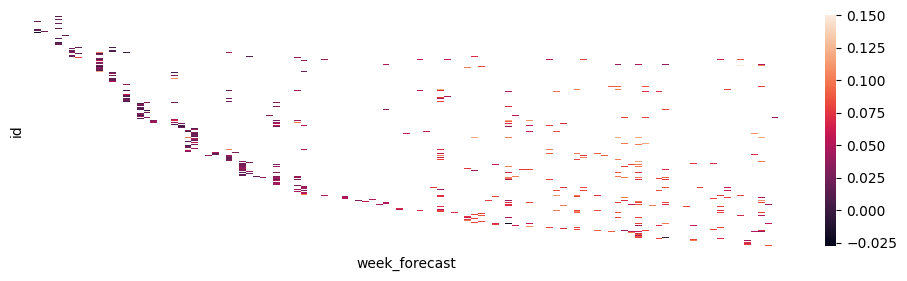

In [10]:
sns.heatmap(
    sub,
    xticklabels=False,
    yticklabels=False,
)

## _i_ exp

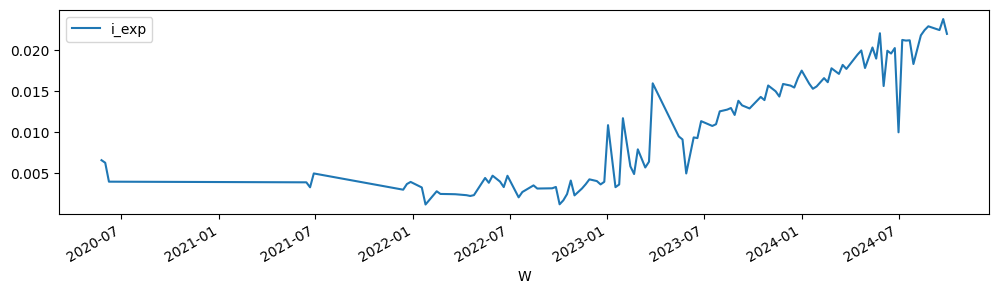

In [62]:
ser = pd_groupby(hhp.set_index('date_forecast'), ['i_exp'], 'W', 'mean').dropna()
ser.plot()
y = ser.values.ravel()

In [ ]:
# using GP constraint to polynomial functions

In [19]:
mod_i_exp, prior_i_epx, trace_i_exp, post_i_exp = get_gp_smoothing(y)

Sampling: [ell, eta, f_rotated_, nu, sigma, y]
C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\pymc\sampling\mcmc.py:273: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:02.461352
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:34:47.466230
Transforming variables...


Sampling: [y]


Transformation time =  0:00:02.016298


''

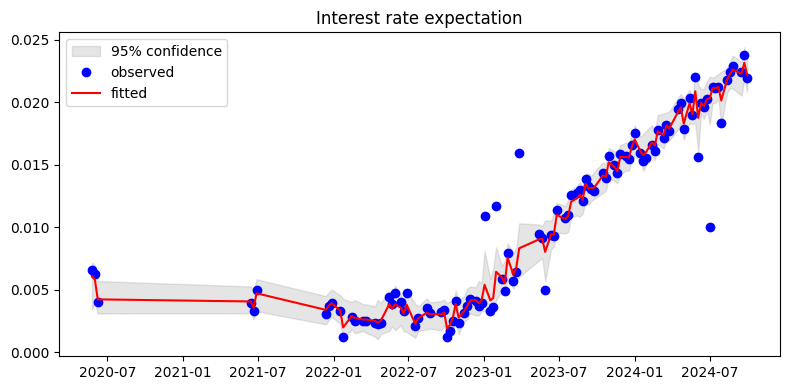

In [63]:
conf = trace_i_exp.posterior['f'][:, get_samp(1_000)].values.reshape(2*100, y.shape[0]).T

fig, ax = plt.subplots(figsize=(8,4))
plt.fill_between(ser.index, np.percentile(conf, 2.5, axis=1), np.percentile(conf, 97.5, axis=1), color='grey', alpha=.2)
ax.plot(ser.index, y, linewidth=0, marker='o', color='blue')
ax.plot(ser.index, trace_i_exp.posterior['f'][:, get_samp(1_000)].values.reshape(2*100,y.shape[0]).mean(axis=0), color='red')
ax.legend(['95% confidence', 'observed', 'fitted'])
ax.set_title('Interest rate expectation')

plt.tight_layout()
save_fig(fig, "pre_hhp_iexp.png")
;

In [64]:
iexp = pd.DataFrame(
        data=trace_i_exp.posterior['f'][:, get_samp(1_000)].values.reshape(2*100,y.shape[0]).mean(axis=0),
        index=ser.index,
        columns=['i_exp_WY']
    )

## pi exp

### mean

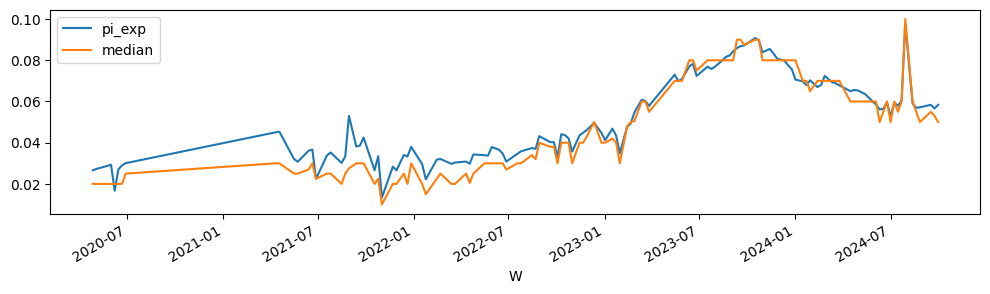

In [65]:
ser = pd_groupby(hhp.set_index('date_forecast'), ['pi_exp'], 'W', 'mean')
# ser.plot()
pd.DataFrame(ser).join(pd_groupby(hhp.set_index('date_forecast'), ['pi_exp'], 'W', 'median').iloc[:,0].rename('median')).plot()
y = ser.values.ravel()

In [21]:
mod_exp, prior_epx, trace_exp, post_exp = get_gp_smoothing(y)

Sampling: [ell, eta, f_rotated_, nu, sigma, y]
C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\pymc\sampling\mcmc.py:273: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:01.906391
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:28:26.711894
Transforming variables...


Sampling: [y]


Transformation time =  0:00:03.859268


''

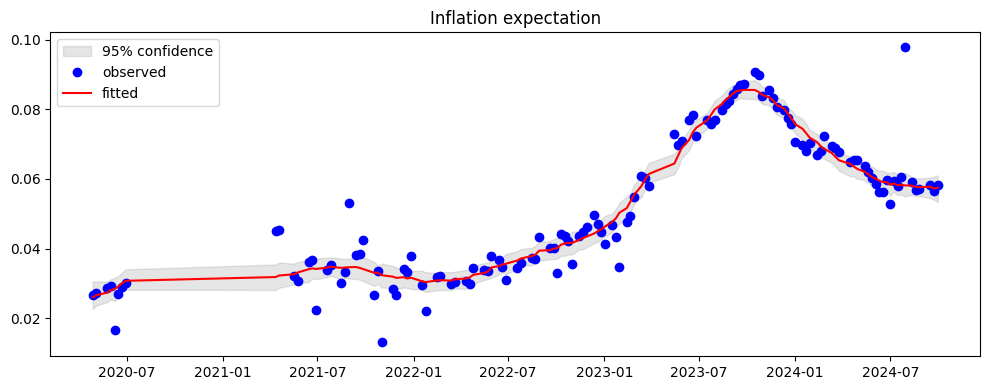

In [66]:
conf = trace_exp.posterior['f'][:, get_samp(1_000)].values.reshape(2*100, y.shape[0]).T

fig, ax = plt.subplots(figsize=(10,4))
plt.fill_between(ser.index, np.percentile(conf, 2.5, axis=1), np.percentile(conf, 97.5, axis=1), color='grey', alpha=.2)
ax.plot(ser.index, y, linewidth=0, marker='o', color='blue')
ax.plot(ser.index, trace_exp.posterior['f'][:, get_samp(1_000)].values.reshape(2*100,y.shape[0]).mean(axis=0), color='red')
ax.legend(['95% confidence', 'observed', 'fitted'])
ax.set_title('Inflation expectation')

plt.tight_layout()
save_fig(fig, "pre_hhp_pi_exp.png")
;

In [67]:
exp = pd.DataFrame(
        data=trace_exp.posterior['f'][:, get_samp(1_000)].values.reshape(2*100,y.shape[0]).mean(axis=0),
        index=ser.index,
        columns=['pi_exp_WY']
    )

### quantiles

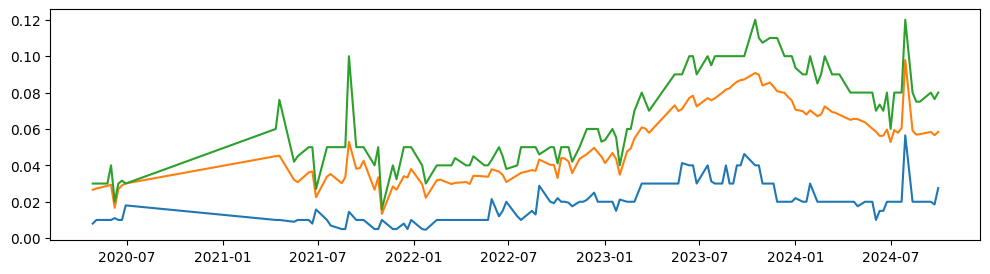

In [38]:
ser_05 = pd_groupby(hhp.set_index('date_forecast'), ['pi_exp'], 'W', 'q_05').rename('q_02.5')
ser = pd_groupby(hhp.set_index('date_forecast'), ['pi_exp'], 'W', 'mean')
ser_95 = pd_groupby(hhp.set_index('date_forecast'), ['pi_exp'], 'W', 'q_80').rename('q_97.5')

plt.plot(pd.DataFrame(ser_05).join(ser).join(ser_95))

y_05 = ser_05.values.ravel()
y_95 = ser_95.values.ravel()

In [64]:
mod_exp_05, prior_epx_05, trace_exp_05, post_exp_05 = get_gp_smoothing(y_05)

Sampling: [ell, eta, f_rotated_, nu, sigma, y]
C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\pymc\sampling\mcmc.py:273: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:01.982264
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:06:52.413587
Transforming variables...


Sampling: [y]


Transformation time =  0:00:01.905443


''

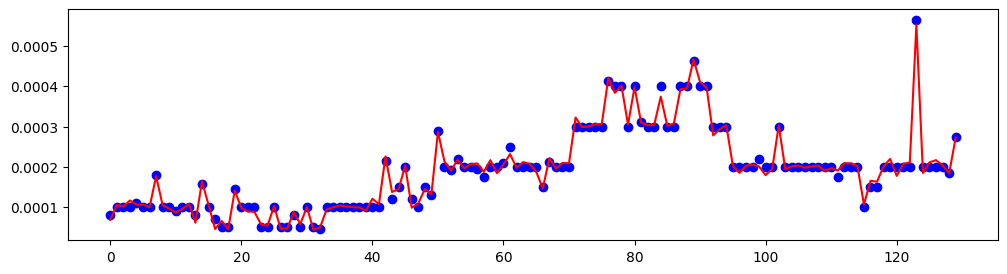

In [69]:
# plt.plot(
#     # trace_exp.posterior['y'][:, get_samp(1_000, 20)].values.reshape(2*20,y.shape[0]).T,
#     trace_exp_05.posterior['f'][:, get_samp(1_000)].values.reshape(2*100, y.shape[0]).T,
#     color='grey', alpha=.1
# )
plt.plot(y_05, linewidth=0, marker='o', color='blue')
plt.plot(trace_exp_05.posterior['f'][:, get_samp(1_000)].values.reshape(2*100,y.shape[0]).mean(axis=0), color='red')
;

In [66]:
mod_exp_95, prior_epx_95, trace_exp_95, post_exp_95 = get_gp_smoothing(y_95)

Sampling: [ell, eta, f_rotated_, nu, sigma, y]
C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\pymc\sampling\mcmc.py:273: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:01.979448
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:26:59.353677
Transforming variables...


Sampling: [y]


Transformation time =  0:00:01.703654


''

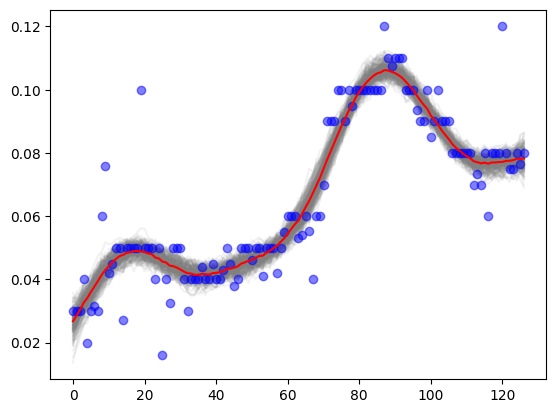

In [70]:
plt.plot(
    trace_exp_95.posterior['f'][:, get_samp(1_000)].values.reshape(2*100, y_95.shape[0]).T,
    color='grey', alpha=.1
)
plt.plot(y_95, linewidth=0, marker='o', alpha=.5, color='blue')
plt.plot(trace_exp_95.posterior['f'][:, get_samp(1_000)].values.reshape(2*100,y_95.shape[0]).mean(axis=0), color='red')
;

In [71]:
exp_q = pd.DataFrame(
        data=trace_exp_05.posterior['f'][:, get_samp(1_000)].values.reshape(2*100, y_05.shape[0]).mean(axis=0),
        index=ser_05.index,
        columns=['pi_exp025_WY']
    )
exp_q['pi_exp975_WY'] = trace_exp_95.posterior['f'][:, get_samp(1_000)].values.reshape(2*100, y_95.shape[0]).mean(axis=0)

# pi perc

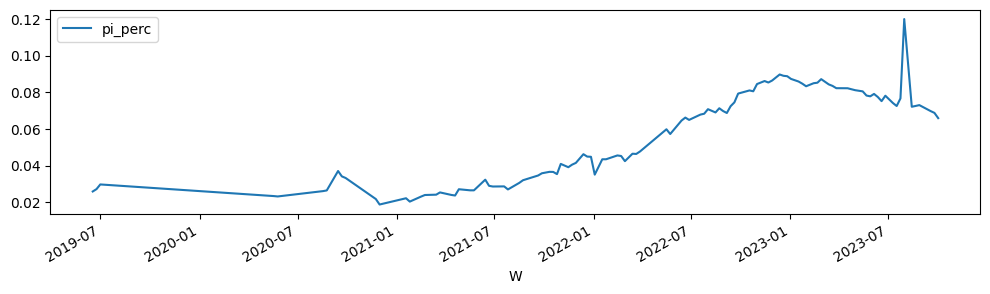

In [125]:
ser = pd_groupby(hhp.set_index('date_recorded'), ['pi_perc'], 'W', 'mean').dropna()
ser.plot()
y = ser.values[:, 0]

In [23]:
mod_perc, prior_perc, trace_perc, post_perc = get_gp_smoothing(y)

Sampling: [ell, eta, f_rotated_, nu, sigma, y]
C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\pymc\sampling\mcmc.py:273: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:03.819347
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:31:35.665875
Transforming variables...


Sampling: [y]


Transformation time =  0:00:01.782510


''

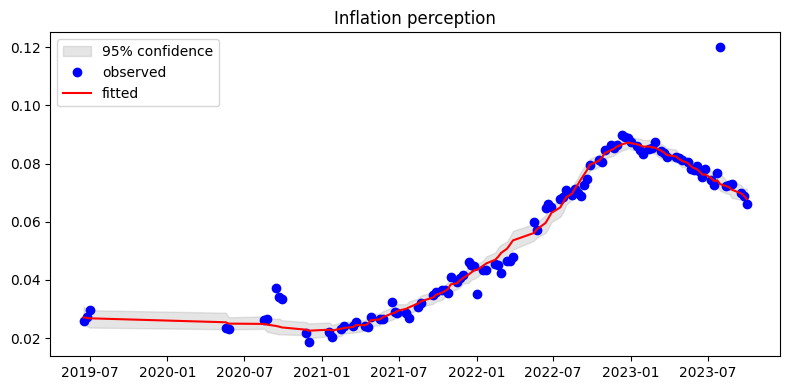

In [126]:
conf = trace_perc.posterior['f'][:, get_samp(1_000)].values.reshape(2*100, y.shape[0]).T

fig, ax = plt.subplots(figsize=(8,4))
plt.fill_between(ser.index, np.percentile(conf, 2.5, axis=1), np.percentile(conf, 97.5, axis=1), color='grey', alpha=.2)
ax.plot(ser.index, y, linewidth=0, marker='o', color='blue')
ax.plot(ser.index, trace_perc.posterior['f'][:, get_samp(1_000)].values.reshape(2*100,y.shape[0]).mean(axis=0), color='red')
ax.legend(['95% confidence', 'observed', 'fitted'])
ax.set_title('Inflation perception')

plt.tight_layout()
save_fig(fig, "pre_hhp_pi_perc.png")
;

In [127]:
perc = pd.DataFrame(
        data=trace_perc.posterior['f'][:, get_samp(1_000)].values.reshape(2*100,y.shape[0]).mean(axis=0),
        index=ser.index,
        columns=['pi_perc_WY']
    )

### quantiles perc

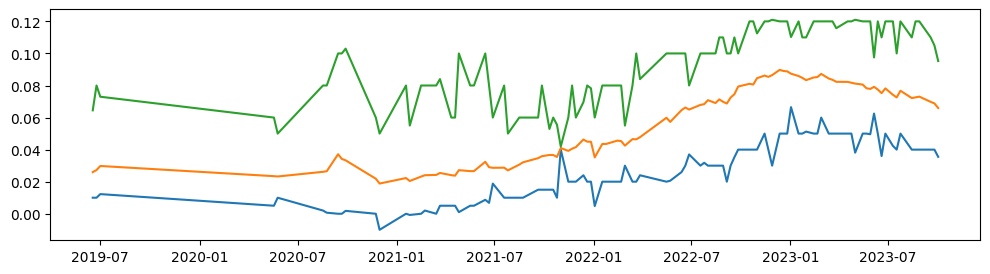

In [128]:
ser_05 = pd_groupby(hhp.set_index('date_recorded'), ['pi_perc'], 'W', 'q_05').rename('q_025').dropna()
ser = pd_groupby(hhp.set_index('date_recorded'), ['pi_perc'], 'W', 'mean').dropna()
ser_95 = pd_groupby(hhp.set_index('date_recorded'), ['pi_perc'], 'W', 'q_95').rename('q_975').dropna()

plt.plot(pd.DataFrame(ser_05).join(ser).join(ser_95))

y_05 = ser_05.values.ravel()
y_95 = ser_95.values.ravel()

In [25]:
mod_perc_05, prior_perc_05, trace_perc_05, post_perc_05 = get_gp_smoothing(y_05)

Sampling: [ell, eta, f_rotated_, nu, sigma, y]
C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\pymc\sampling\mcmc.py:273: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:01.797952
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:17:33.446660
Transforming variables...


Sampling: [y]


Transformation time =  0:00:01.655889


''

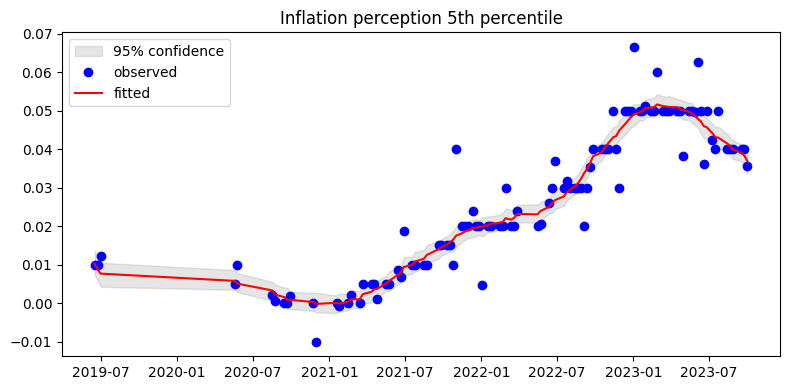

In [129]:
conf = trace_perc_05.posterior['f'][:, get_samp(1_000)].values.reshape(2*100, y_05.shape[0]).T

fig, ax = plt.subplots(figsize=(8,4))
plt.fill_between(ser_05.index, np.percentile(conf, 2.5, axis=1), np.percentile(conf, 97.5, axis=1), color='grey', alpha=.2)
ax.plot(ser_05.index, y_05, linewidth=0, marker='o', color='blue')
ax.plot(ser_05.index, trace_perc_05.posterior['f'][:, get_samp(1_000)].values.reshape(2*100,y_05.shape[0]).mean(axis=0), color='red')
ax.legend(['95% confidence', 'observed', 'fitted'])
ax.set_title('Inflation perception 5th percentile')

plt.tight_layout()
save_fig(fig, "pre_hhp_pi_perc05.png")
;

In [26]:
mod_perc_95, prior_perc_95, trace_perc_95, post_perc_95 = get_gp_smoothing(y_95)

Sampling: [ell, eta, f_rotated_, nu, sigma, y]
C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\pymc\sampling\mcmc.py:273: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:01.756936
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:13:56.065104
Transforming variables...


Sampling: [y]


Transformation time =  0:00:01.109922


''

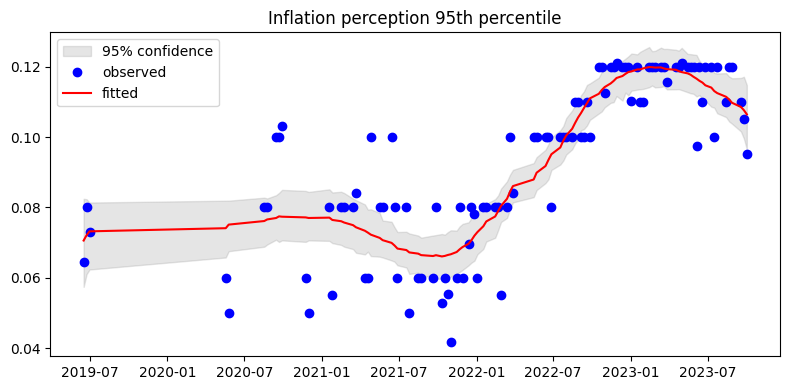

In [130]:
conf = trace_perc_95.posterior['f'][:, get_samp(1_000)].values.reshape(2*100, y_95.shape[0]).T

fig, ax = plt.subplots(figsize=(8,4))
plt.fill_between(ser_95.index, np.percentile(conf, 2.5, axis=1), np.percentile(conf, 97.5, axis=1), color='grey', alpha=.2)
ax.plot(ser_95.index, y_95, linewidth=0, marker='o', color='blue')
ax.plot(ser_95.index, trace_perc_95.posterior['f'][:, get_samp(1_000)].values.reshape(2*100,y_95.shape[0]).mean(axis=0), color='red')
ax.legend(['95% confidence', 'observed', 'fitted'])
ax.set_title('Inflation perception 95th percentile')

plt.tight_layout()
save_fig(fig, "pre_hhp_pi_perc95.png")
;

In [131]:
perc_q = pd.DataFrame(
        data=trace_perc_05.posterior['f'][:, get_samp(1_000)].values.reshape(2*100, y_05.shape[0]).mean(axis=0),
        index=ser_05.index,
        columns=['pi_perc05_WY']
    )
perc_q['pi_perc95_WY'] = trace_perc_95.posterior['f'][:, get_samp(1_000)].values.reshape(2*100, y_95.shape[0]).mean(axis=0)

## delta perc exp

In [134]:
_ = pd.DataFrame(
    hhp.set_index('date_recorded')[['pi_perc', 'pi_exp']].apply(lambda x: x['pi_perc'] - x['pi_exp'], axis=1).dropna().rename('delta_pe')
).copy()

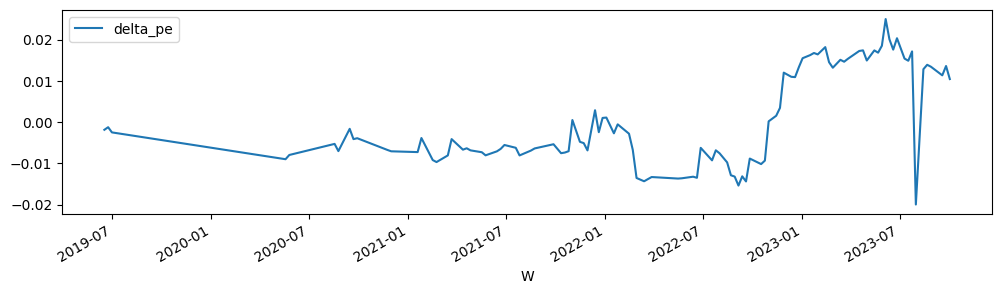

In [135]:
ser = pd_groupby(_, ["delta_pe"], "W", "mean").dropna()
ser.plot()
y = ser.values[:, 0]

In [29]:
mod_delta_pe, prior_delta_pe, trace_delta_pe, post_delta_pe = get_gp_smoothing(y)

Sampling: [ell, eta, f_rotated_, nu, sigma, y]
C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\pymc\sampling\mcmc.py:273: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:01.953591
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:05:19.982339
Transforming variables...


Sampling: [y]


Transformation time =  0:00:01.172478


''

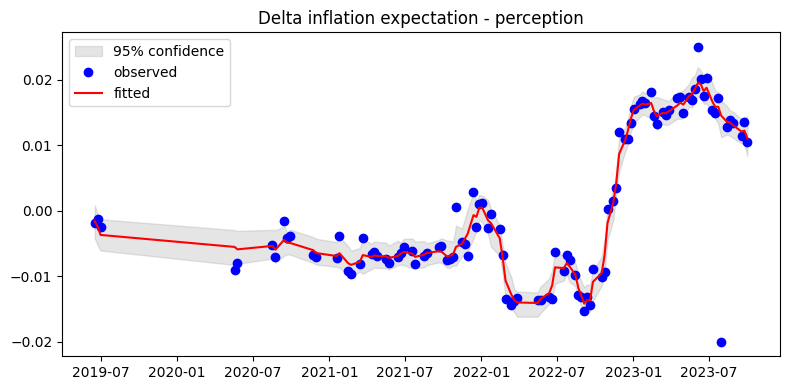

In [136]:
conf = trace_delta_pe.posterior['f'][:, get_samp(1_000)].values.reshape(2*100, y.shape[0]).T

fig, ax = plt.subplots(figsize=(8,4))
plt.fill_between(ser.index, np.percentile(conf, 2.5, axis=1), np.percentile(conf, 97.5, axis=1), color='grey', alpha=.2)
ax.plot(ser.index, y, linewidth=0, marker='o', color='blue')
ax.plot(ser.index, trace_delta_pe.posterior['f'][:, get_samp(1_000)].values.reshape(2*100,y.shape[0]).mean(axis=0), color='red')
ax.legend(['95% confidence', 'observed', 'fitted'])
ax.set_title('Delta inflation expectation - perception')

plt.tight_layout()
save_fig(fig, "pre_hhp_delta_pe.png")
;

In [137]:
delta_pe = pd.DataFrame(
        data=trace_delta_pe.posterior['f'][:, get_samp(1_000)].values.reshape(2*100,y.shape[0]).mean(axis=0),
        index=ser.index,
        columns=['delta_pe_WY']
    )

In [138]:
delta_pe = delta_pe.join(ser)

# save df

In [139]:
perc['pi_perc_WY_diff'] = perc.pi_perc_WY.diff()
exp['pi_exp_WY_diff'] = exp.pi_exp_WY.diff()
iexp['i_exp_WY_diff'] = iexp.i_exp_WY.diff()

In [140]:
delta_pe['delta_pe_WY_diff'] = delta_pe.delta_pe_WY.diff()

In [26]:
exp_q['pi_exp975_WY_diff'] = exp_q.pi_exp975_WY.diff()
exp_q['pi_exp025_WY_diff'] = exp_q.pi_exp025_WY.diff()

In [141]:
perc_q['pi_perc05_WY_diff'] = perc_q.pi_perc05_WY.diff()
perc_q['pi_perc95_WY_diff'] = perc_q.pi_perc95_WY.diff()

In [142]:
perc.index.name = 'date_recorded'
exp.index.name = 'date_forecast'
iexp.index.name = 'date_forecast'

In [143]:
delta_pe.index.name = 'date_recorded'

In [ ]:
exp_q.index.name = 'date_forecast'

In [144]:
perc_q.index.name = 'date_recorded'

In [145]:
_ = pd_groupby(delta_pe, ['delta_pe_WY'], 'M', 'last')
_.columns = ['delta_pe_MY']
_.index.name = 'date'
delta_pe = pd_join_freq(delta_pe, _, 'M').set_index('date_recorded')

In [30]:
_ = pd_groupby(exp_q, ['pi_exp975_WY', 'pi_exp025_WY'], 'M', 'last')
_.columns = ['pi_exp975_MY', 'pi_exp025_MY']
_.index.name = 'date'
exp_q = pd_join_freq(exp_q, _, 'M').set_index('date_forecast')

In [146]:
_ = pd_groupby(perc_q, ['pi_perc95_WY', 'pi_perc05_WY'], 'M', 'last')
_.columns = ['pi_perc95_MY', 'pi_perc05_MY']
_.index.name = 'date'
perc_q = pd_join_freq(perc_q, _, 'M').set_index('date_recorded')

In [150]:
_ = pd_groupby(perc, ['pi_perc_WY'], 'M', 'last')
_.columns = ['pi_perc_MY']
_.index.name = 'date'
perc = pd_join_freq(perc, _, 'M').set_index('date_recorded')

In [151]:
_ = pd_groupby(exp, ['pi_exp_WY'], 'M', 'last')
_.columns = ['pi_exp_MY']
_.index.name = 'date'
exp = pd_join_freq(exp, _, 'M').set_index('date_forecast') # axis=1)

In [152]:
_ = pd_groupby(iexp, ['i_exp_WY'], 'M', 'last')
_.columns = ['i_exp_MY']
_.index.name = 'date'
iexp = pd_join_freq(iexp, _, 'M').set_index('date_forecast') # axis=1)

In [153]:
save_pd_df(perc, 'hhp_perc.feather')
save_pd_df(exp, 'hhp_exp.feather')
save_pd_df(iexp, 'hhp_iexp.feather')

In [154]:
save_pd_df(exp_q, 'hhp_exp_q.feather')
save_pd_df(delta_pe, 'hhp_delta_pe.feather')

In [155]:
save_pd_df(perc_q, 'hhp_perc_q.feather')